# 1.2 Classify cells

## Simple setup
To use the `src` module inside of the notebooks:

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import janitor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
import src

sns.set_style("whitegrid")

## Load data

In [3]:
experiments_file = src.data_processed_dir("experiments_data.csv")
experiments_file.exists()

True

In [4]:
experiments_df = pd.read_csv(filepath_or_buffer=experiments_file)
experiments_df.head()

,lineage_id,track_id,cell_id,mother_id,frame,roi_id,length,division,dead,gfp,dsred,file_name_id,experiment_id
0,0.0,10.8-34.0,10.8,10.8,0,roi_f10_n8_x129_y214,25.849682,0.0,0.0,120.110,108.394,MGGT-AMP-Pulse_xy01_lineages_all.csv,chromosome_lineages
1,0.0,10.8-34.0,11.6,10.8,1,roi_f11_n6_x126_y216,41.415207,1.0,0.0,120.289,108.422,MGGT-AMP-Pulse_xy01_lineages_all.csv,chromosome_lineages
2,0.0,10.8-34.0,12.8,10.8,2,roi_f12_n8_x122_y225,19.348009,0.0,0.0,119.765,107.959,MGGT-AMP-Pulse_xy01_lineages_all.csv,chromosome_lineages
3,0.0,10.8-34.0,13.8,10.8,3,roi_f13_n8_x124_y224,26.301427,0.0,0.0,119.771,108.061,MGGT-AMP-Pulse_xy01_lineages_all.csv,chromosome_lineages
4,0.0,10.8-34.0,14.5,10.8,4,roi_f14_n5_x124_y220,26.475045,0.0,0.0,119.718,107.977,MGGT-AMP-Pulse_xy01_lineages_all.csv,chromosome_lineages


## Look to normal state distribution

In [5]:
antibiotic_start_frame = 6

In [6]:
control_stats_df = (
    experiments_df
    .select_columns(["experiment_id", "frame", "length", "gfp", "dsred"])
    .assign(with_antibiotic=lambda df: df.frame >= antibiotic_start_frame)
    .filter_on("not with_antibiotic")
    .select_columns(["frame", "with_antibiotic"], invert=True)
    .groupby(["experiment_id"])
    .aggregate([
        ("mean", "mean"),
        ("median", "median"),
        ("std", "std"),
        ("skew", "skew"),
        ("variation", ss.variation)
    ])
)

control_stats_df.head()

length                                            \
                          mean     median        std      skew variation   
experiment_id                                                              
chromosome_lineages  26.217203  25.167455   6.517328  1.430240  0.248581   
plasmid_lineages     28.400235  26.197345  11.572399  4.241343  0.407473   

                            gfp                                          \
                           mean   median        std      skew variation   
experiment_id                                                             
chromosome_lineages  122.081444  121.613   3.286610  1.717586  0.026920   
plasmid_lineages     268.398912  259.630  59.197792  1.641015  0.220558   

                          dsred                                         
                           mean   median       std      skew variation  
experiment_id                                                           
chromosome_lineages  107.720018  107.667  0.423146  0.716356  0.003928  
plasmid_lineages      98.023016   98.000  0.305190  0.471116  0.003113

## Define threshold to consider if cell is filamentaded

In [7]:
filamentation_thresholds = (
    control_stats_df["length"]
    .apply(lambda df: df["mean"] + 2 * df["std"], axis=1)
    .reset_index(name="filamentation_threshold")
)

filamentation_thresholds

,experiment_id,filamentation_threshold
0,chromosome_lineages,39.251859
1,plasmid_lineages,51.545032


## Join data

In [8]:
experiments_df2 = experiments_df.merge(filamentation_thresholds, on="experiment_id")
experiments_df2.head()

,lineage_id,track_id,cell_id,mother_id,frame,roi_id,length,division,dead,gfp,dsred,file_name_id,experiment_id,filamentation_threshold
0,0.0,10.8-34.0,10.8,10.8,0,roi_f10_n8_x129_y214,25.849682,0.0,0.0,120.110,108.394,MGGT-AMP-Pulse_xy01_lineages_all.csv,chromosome_lineages,39.251859
1,0.0,10.8-34.0,11.6,10.8,1,roi_f11_n6_x126_y216,41.415207,1.0,0.0,120.289,108.422,MGGT-AMP-Pulse_xy01_lineages_all.csv,chromosome_lineages,39.251859
2,0.0,10.8-34.0,12.8,10.8,2,roi_f12_n8_x122_y225,19.348009,0.0,0.0,119.765,107.959,MGGT-AMP-Pulse_xy01_lineages_all.csv,chromosome_lineages,39.251859
3,0.0,10.8-34.0,13.8,10.8,3,roi_f13_n8_x124_y224,26.301427,0.0,0.0,119.771,108.061,MGGT-AMP-Pulse_xy01_lineages_all.csv,chromosome_lineages,39.251859
4,0.0,10.8-34.0,14.5,10.8,4,roi_f14_n5_x124_y220,26.475045,0.0,0.0,119.718,107.977,MGGT-AMP-Pulse_xy01_lineages_all.csv,chromosome_lineages,39.251859


## Filamentation proportions

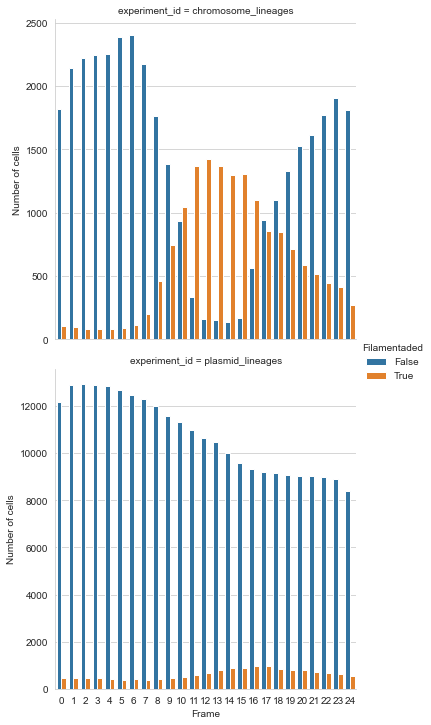

In [9]:
(
    experiments_df2
    .assign(Filamentaded=lambda df: df.length >= df.filamentation_threshold)
    .pipe(lambda df:
        sns.catplot(
            data=df,
            x="frame",
            hue="Filamentaded",
            kind="count",
            row="experiment_id",
            sharey=False
        )
    )
    .set_axis_labels("Frame", "Number of cells")
)